In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import matplotlib as mpl
import os


In [12]:
def init_fig(aspect=(4,3),font_size=16,X=1,Y=1,sharex=False,sharey=False):
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('axes', labelsize=font_size)
    params = {'legend.fontsize': 'larger',
              'legend.handlelength': 2}
    plt.rcParams.update(params)

    fig,ax =plt.subplots(X,Y,figsize=aspect,sharex=sharex,sharey=sharey)
    
    return ax,fig


# Figure 1

(0.0, 1.6)

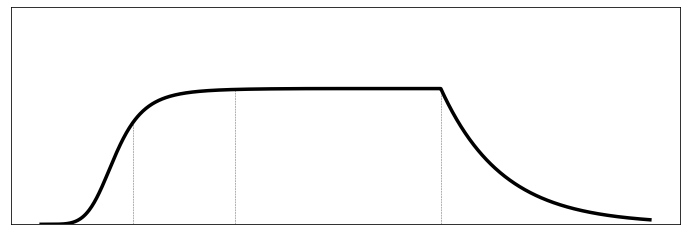

In [8]:
# Long-term addiction panel

t=np.linspace(0,99,1000)
T_POINT = 15
A_POINT =45
B_POINT =65
def a_func(tt,thalf=12,NN=5):
    return tt**NN/(tt**NN+thalf**NN)

def b_func(tt,gamma=.1):
    return a_func(A_POINT)*np.exp(gamma*(B_POINT-tt))


def func(tt,):
    if tt<A_POINT:
        return a_func(tt)
    elif tt>B_POINT:
        return b_func(tt)
    else:
        return a_func(A_POINT)

f = np.vectorize(func)
ax,fig = init_fig(aspect=(12,4))
ax.plot(t,f(t),lw=3.5,c='k')
ax.vlines(A_POINT*.7,0,1,linestyles='dashed',lw=.5)
ax.vlines(B_POINT,0,1,linestyles='dashed',lw=.5)
ax.vlines(T_POINT,0,.75,linestyles='dashed',lw=.5)

ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(0,1.6)


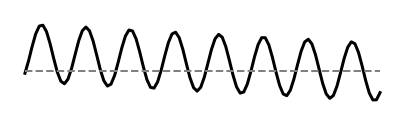

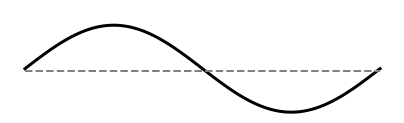

In [9]:
# Opponent process illustration

t=np.linspace(0,99,100)
tC=70
PERIOD=8/max(t)
fs = {'B2' : ("mood",((.97-0.0027*t)+0.4*np.cos(1.25*np.pi+PERIOD*t*np.pi*2),-100+0*t,0.72+0*t)),
      'BB2' : ("mood",(.75+0.6*np.sin(0.125*PERIOD*t*np.pi*2),-100+0*t,0.72+0*t))}
clist = ['k','grey','grey']
for title,item in fs.items():
    key,f=item
    ax,fig=init_fig(aspect=(7,2))
    ax.set_yticks(())
    ax.set_xticks(())
    for func,c in zip(f,clist[:len(clist)]):
        ls = 'solid'
        if title[-1]=='1':
            lw=2
        else:
            lw=3
        if c == 'grey':
            ls = 'dashed'
            lw = 2
        ax.plot(t,func,lw=lw,c=c,linestyle=ls)
        ax.axis('off')
        
    ax.set_ylim((0.1,1.6))
    

# Circuits

In [10]:
SLOW_Z = (24*60*5)
FAST_R = 10

@np.vectorize
def utility_saturation(x): 
    return 1/(1+x**-5)

class Circuit(object):
    def __init__(self):
        pass

    def eqs(self,y,t,u,pars):
        raise NotImplemented
        
        
    def initialize(self,u,tmax=200*24*60):
        simple_initvals = np.repeat(1,len(self.rates))
        t = np.linspace(0, tmax,tmax)
        sol = odeint(self.__class__.eqs, simple_initvals, t, args=(u,self.rates,self.pars))
        return sol[-1]
    
    def run_input(self,u,y0,tmax):
        t = np.linspace(1, tmax,tmax)
        sol = odeint(self.__class__.eqs, y0, t, args=(u,self.rates,self.pars))
        return t,sol,np.vectorize(u)(t)
    
    
    def utility(self,y0,u,tmax=None):
        if tmax==None:
            tmax = 24*60
        
        t = np.linspace(1, tmax,tmax)
        sol = odeint(self.__class__.eqs, y0, t,args=(u,self.rates,self.pars))
        reward = utility_saturation(sol[:,self.names.index("x")])
        reward = reward * (0.99**t)
        
        return reward.mean(),sol[-1]
    
    def change_utility(self,u0,u1):
        """
        returns the utility of changing from u0 to u1
        """
        y0 = self.initialize(u0)
        return self.utility(y0,u1)
    
    def calc_rewards(self,y,u,ub):
        s_t = self.utility(y,lambda t: u)[0]
        s_t_b = self.utility(y,lambda t: ub)[0]
        withdrawal_reward = s_t_b
        drug_induced_reward = s_t
        return withdrawal_reward,drug_induced_reward
    

class Stress(Circuit):
    def __init__(self,kGR,glands=True):
        self.rates = {"gamma_h"    : np.log(2)/4,
                      "gamma_beta" : np.log(2)/37,
                      "gamma_p"    : np.log(2)/20,
                      "gamma_a"    : np.log(2)/76,
                      "gamma_P"    : np.log(2)/(6*24*60),
                      "gamma_A"    : np.log(2)/(12*24*60)}
        self.pars = {"kGR" : kGR}
        self.names = ["CRH",r"$\beta$-endorphin","ACTH","cortisol","corticotroph mass","adrenal mass"]
    def eqs(y,t,u,rates,pars):
        MR = lambda a: np.divide(1,a)
        GR = lambda a,kGR: np.divide(1,np.power(np.divide(a,kGR),3)+1)
        h, beta, p, a, P, A = y
        


        dydt = [rates["gamma_h"]*(u(t)*MR(a)*GR(a,pars["kGR"])-h), 
                rates["gamma_beta"]*(h*GR(a,pars["kGR"])*P-beta), 
                rates["gamma_p"]*(h*GR(a,pars["kGR"])*P-p), 
                rates["gamma_a"]*(p*A-a),
                rates["gamma_P"]*P*(h-1),
                rates["gamma_A"]*A*(p-1)]
        return dydt      



class Activation(Circuit):
    def __init__(self):
        self.rates = {"gamma_x" : np.log(2)/FAST_R}
        self.pars = {}
        self.names = ["x",]
    def eqs(y,t,u,rates,pars):
        x = y[0]

        dydt = [rates["gamma_x"]*(u(t)-x),]
        return dydt


class NegativeFeedback(Circuit):
    def __init__(self):
        self.rates = {"gamma_x" : np.log(2)/FAST_R,
                      "gamma_Z" : np.log(2)/SLOW_Z}
        self.pars = {}
        self.names = ["x","Z"]
    def eqs(inp,t,u,rates,pars):
        x,Z = inp

        dydt = [rates["gamma_x"]*(u(t)*(Z**-1)-x),
                rates["gamma_Z"]*(x-Z)]
        return dydt
    

class PositiveFeedback(Circuit):
    def __init__(self):
        self.rates = {"gamma_x" : np.log(2)/FAST_R,
                      "gamma_Z" : np.log(2)/SLOW_Z}
        self.pars = {}
        self.names = ["x","Z"]
    def eqs(inp,t,u,rates,pars):
        x,Z = inp

        dydt = [rates["gamma_x"]*(u(t)*(Z**0.5)-x),
                rates["gamma_Z"]*(x-Z)]
        return dydt
    
class FCDCircuit(Circuit):
    def __init__(self):
        self.rates = {"gamma_x" : np.log(2)/FAST_R,
                      "gamma_Z" : np.log(2)/SLOW_Z}
        self.pars = {}
        self.names = ["x","Z"]
    def eqs(y,t,u,rates,pars):
        x, Z = y

        dydt = [rates["gamma_x"]*(u(t)/Z-x), 
                rates["gamma_Z"]*Z*(x-1)
                ]
        return dydt      




# Figure 2

In [11]:
KGR_VAL = 8

<ipython-input-12-3ffe526f93ab>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax =plt.subplots(X,Y,figsize=aspect,sharex=sharex,sharey=sharey)


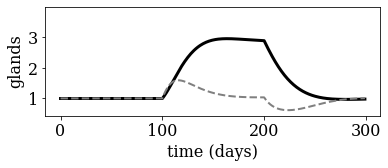

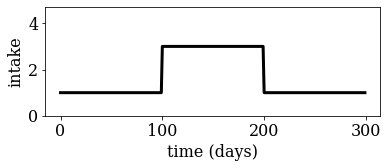

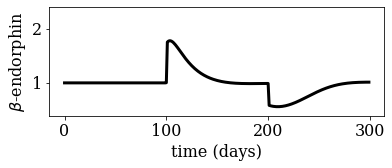

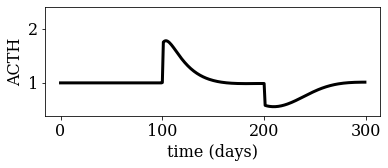

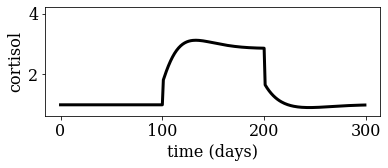

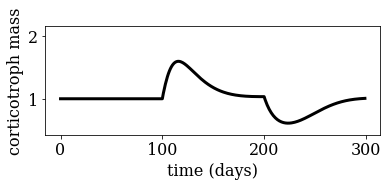

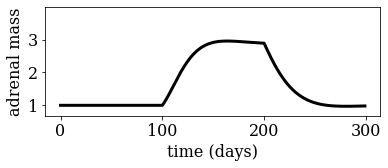

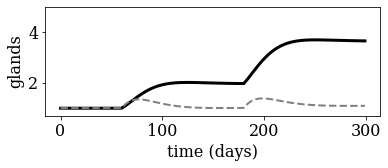

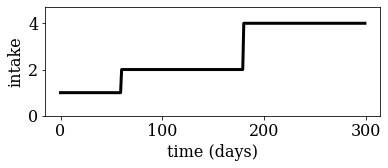

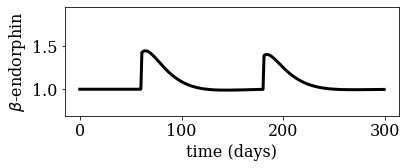

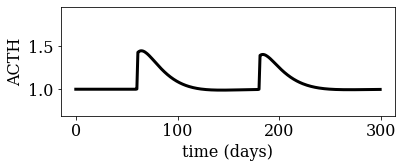

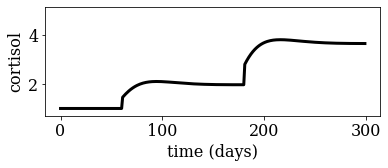

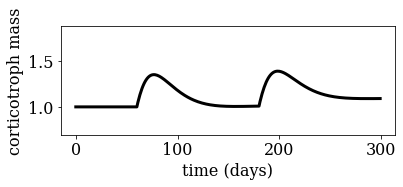

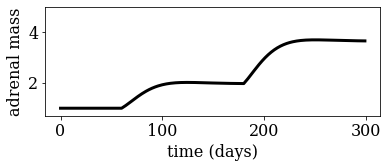

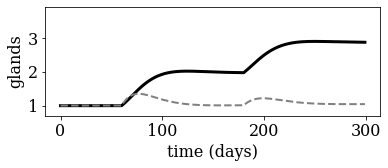

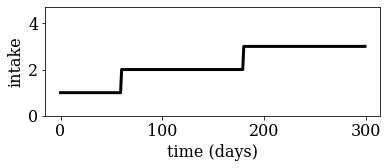

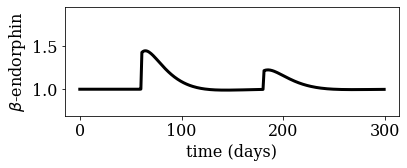

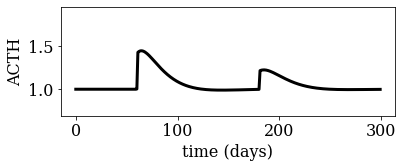

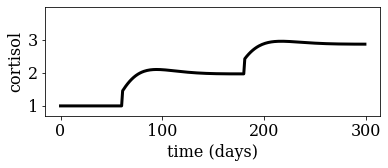

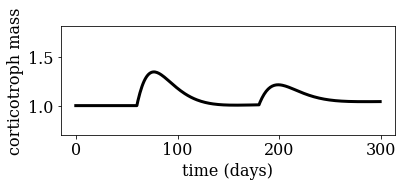

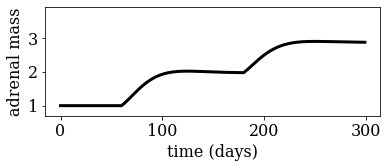

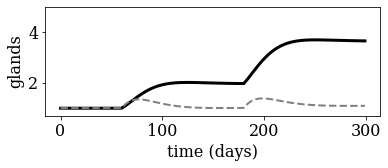

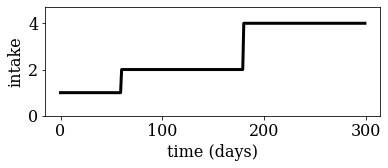

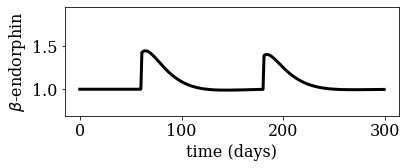

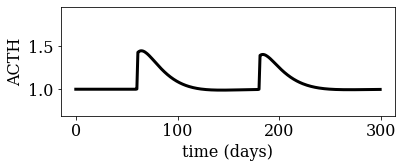

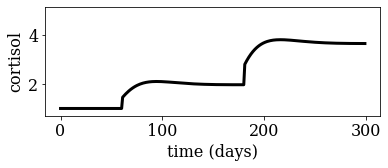

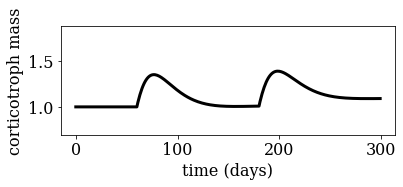

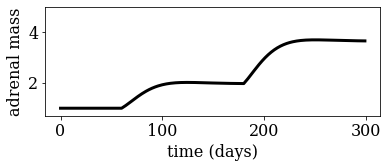

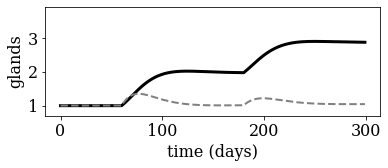

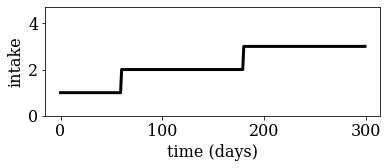

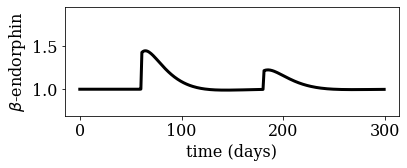

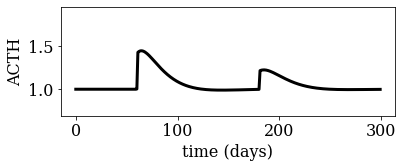

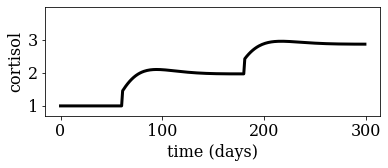

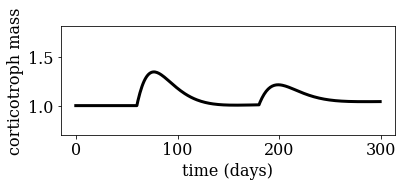

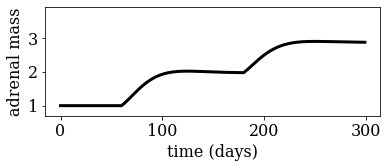

In [13]:
def fold(t):
    if t < 60*24*60:
        return 1
    elif t < 180*24*60:
        return 2
    else:
        return 4

def linear(t):
    if t < 60*24*60:
        return 0
    elif t < 180*24*60:
        return 1
    else:
        return 2
    
def generate_plot(ax,fig,t,sol,name,min_zero=False):
    
    mx = 4.7 if name=="intake" else 1.35*np.max(sol)
    if min_zero:
        mn = 0
    else:
        mn = 0.7*np.min(sol)
    colors = ['k','gray']
    lw = [3,2]
    ls = ['solid','dashed']
    for s,i in zip(sol.T,range(sol.shape[1])):
        ax.plot(t/(24*60),s, color=colors[i], ls=ls[i],linewidth=lw[i],alpha=1)
    ax.set_ylim((mn,mx))
    ax.set_ylabel(name)
    ax.set_xlabel('time (days)')


    
def run_and_plot_ufunc(ufunc,U0,TMAX,glands=True):
    stress_circuit = Stress(KGR_VAL,glands=glands)
    y0 = stress_circuit.initialize(lambda x: U0)
    t,sol,u = stress_circuit.run_input(ufunc,y0,TMAX)
    ax,fig = init_fig(aspect=(6,2))
    generate_plot(ax,fig,t[::24*60],
                  sol[::24*60,[stress_circuit.names.index("adrenal mass"),stress_circuit.names.index("corticotroph mass")]],
                  name='glands')
    
    ax,fig = init_fig(aspect=(6,2))
    inp = u[::24*60,]
    inp = inp.reshape((inp.shape[0],1))
    generate_plot(ax,fig,t[::24*60],inp,name='intake',min_zero=True)
    for name in stress_circuit.names[1:]:
        ax,fig = init_fig(aspect=(6,2))
        generate_plot(ax,fig,t[::24*60],sol[::24*60,[stress_circuit.names.index(name)]],name=name)
    
        
TMAX=300*24*60
U0=1
STEPS = 2
WIDTH = 2
ufunc_exponential = lambda tt: U0*fold(tt)
ufunc_linear = lambda tt: U0*(1+linear(tt))
ufunc_pulse = lambda tt: U0+(2*U0*(tt<200*24*60)*(tt>100*24*60))
run_and_plot_ufunc(ufunc_pulse,U0,TMAX)
run_and_plot_ufunc(ufunc_exponential,U0,TMAX)
run_and_plot_ufunc(ufunc_linear,U0,TMAX)
run_and_plot_ufunc(ufunc_exponential,U0,TMAX,glands=False)
run_and_plot_ufunc(ufunc_linear,U0,TMAX,glands=False)


# Figure 3

(0.0, 5.0)

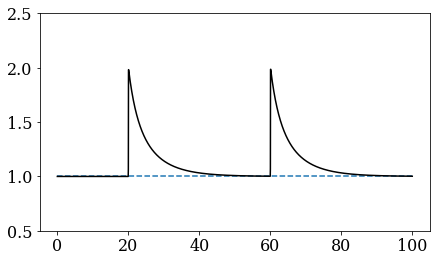

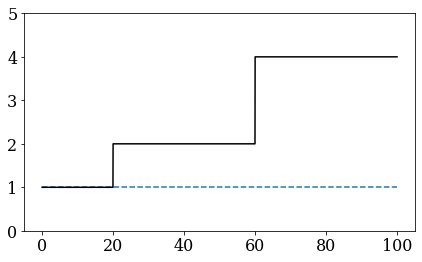

In [14]:
circuit=FCDCircuit()
U0=1
TMAX = 100*24*60
jlist = [20,60]
ufunc = lambda tt: 2**(np.sum([1*(tt>j*24*60) for j in jlist]))

y0 = circuit.initialize(lambda x: U0)
t,sol,u = circuit.run_input(ufunc,y0,TMAX)
ax,fig = init_fig(aspect=(7,4))

ax.plot(t[::60]/(24*60),sol[::60,circuit.names.index('x')],color='k')
ax.hlines(1,t[0]/(24*60),t[-1]/(24*60),linestyle='dashed')
ax.set_ylim(0.5,2.5)

ax,fig = init_fig(aspect=(7,4))

ax.plot(t[::60]/(24*60),np.vectorize(ufunc)(t[::60]),color='k')
ax.hlines(1,t[0]/(24*60),t[-1]/(24*60),linestyle='dashed')
ax.set_ylim(0,5)


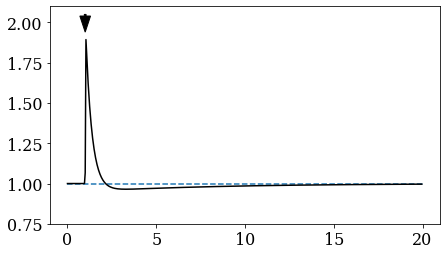

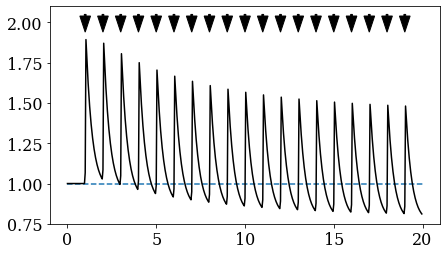

In [15]:
circuit=FCDCircuit()
U0=1
TMAX = 20*24*60
for jlist,title in  zip(([1,],np.arange(1,TMAX/(24*60),1)),("single","many")):
    half_life = np.log(2)/(6*60)
    ufunc = lambda tt: 1 + np.sum([1*(tt>j*24*60)*np.exp(-half_life*(tt-j*24*60)) for j in jlist])
    y0 = circuit.initialize(lambda x: U0)
    t,sol,u = circuit.run_input(ufunc,y0,TMAX)
    ax,fig = init_fig(aspect=(7,4))

    ax.plot(t[::60]/(24*60),sol[::60,circuit.names.index('x')],color='k')
    ax.hlines(1,t[0]/(24*60),t[-1]/(24*60),linestyle='dashed')
    ax.set_ylim(0.75,2.1)
    _=[ax.arrow(jj,2.05,-0,-0.01,width=0.1,head_length=0.1,head_width=0.6,color='k') for jj in jlist]


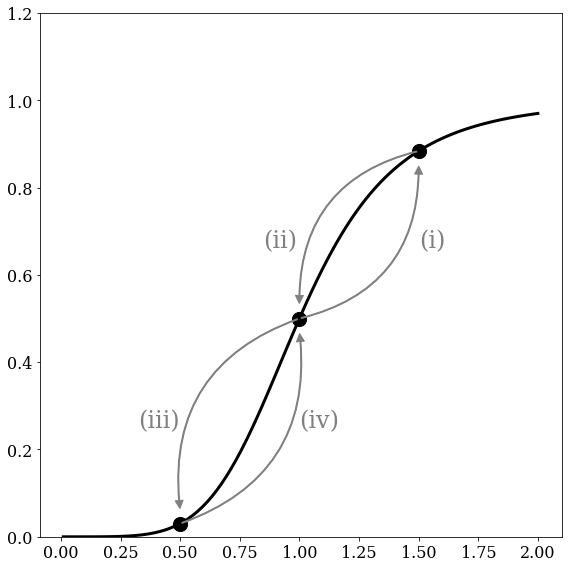

In [16]:
import matplotlib.patches as patches

ax,fig=init_fig(aspect=(8,8))

bend_vals=np.linspace(0.01,2,100)
ptsX = np.array([0.5,1,1.5])
ptsY = utility_saturation(ptsX)
ax.plot(bend_vals,utility_saturation(bend_vals),c='k',lw=3,zorder=-1)
ax.scatter(ptsX,ptsY,c='k',s=200,zorder=1)


style="Simple,tail_width=1,head_width=8,head_length=8"
kw = dict(arrowstyle=style, color="gray")
arrows = []
for i in range(2):
    arrows.append(patches.FancyArrowPatch((ptsX[i],ptsY[i]), (ptsX[i+1],ptsY[i+1]-0.03),
                                          connectionstyle="arc3,rad=.4", **kw))
    arrows.append(patches.FancyArrowPatch((ptsX[i+1],ptsY[i+1]), (ptsX[i],ptsY[i]+0.03),
                                          connectionstyle="arc3,rad=.4", **kw))
[plt.gca().add_patch(a) for a in arrows]

ax.set_ylim(0,1.2)
ax.text(ptsX[2],ptsY[2]*.75,'(i)',fontsize=24,color='gray')
ax.text(ptsX[1]*.85,ptsY[2]*.75,'(ii)',fontsize=24,color='gray')
ax.text(ptsX[0]*.65,ptsY[1]*.5,'(iii)',fontsize=24,color='gray')
ax.text(ptsX[1],ptsY[1]*.5,'(iv)',fontsize=24,color='gray')
plt.tight_layout()

In [17]:
TMAX=200
def run_linear_input(circuit):
    U0=1
    FF=3
    y0=circuit.initialize(lambda t: U0)
    sol = []
    for i in range(TMAX):
        UT = U0+FF*float(i)/TMAX
        _,y,_=circuit.run_input(lambda t:UT,y0,24*60)
        y0=y[-1]
        sol.append(circuit.calc_rewards(y0,UT,U0)) #mood,wanting,liking
    return sol


In [18]:
circuits = [Activation(),PositiveFeedback(),NegativeFeedback(),FCDCircuit()]
sols = [run_linear_input(c) for c in circuits]

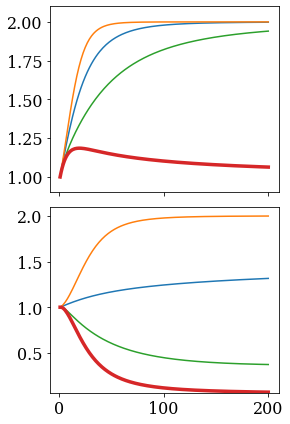

In [19]:

t = np.linspace(1,TMAX,TMAX)
axs,fig=init_fig(aspect=(4,6),X=2,Y=1,sharex=True)
ax = axs[0]
for idx,ax in zip((1,0),axs):
    for sol,circuit in zip(sols,circuits):
        norm_sol = np.array(sol)/sol[0]
        lw = 3.5 if ("FCDCircuit" in circuit.__str__()) else 1.5
        ax.plot(t,norm_sol[:,idx],lw=lw)
    ax.set_ylim(np.min(np.min([np.array(sol)/sol[0] for sol in sols],axis=1)[:,idx])*.9,2.1)
fig.tight_layout()    

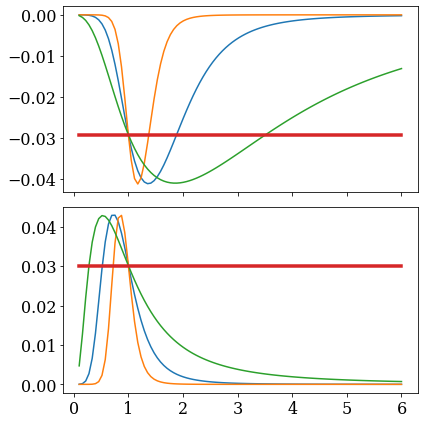

In [20]:
z = np.linspace(0.1,6,100)

def get_gen_inp(circuit,ratio=.5):
    @np.vectorize
    def gen_inp(u):
        a = circuit.change_utility(lambda t: u,lambda t: u*ratio)[0]
        b = circuit.change_utility(lambda t: u,lambda t: u*1)[0]
        return a-b
    return gen_inp

axs,fig=init_fig(aspect=(6,6),X=2,Y=1,sharex=True)
for ax,ratio in zip(axs,(0.5,2)):
    for circuit in circuits:
        lw = 3.5 if ("FCDCircuit" in circuit.__str__()) else 1.5
        ax.plot(z,get_gen_inp(circuit,ratio)(z),lw=lw)
fig.tight_layout()



# Figure 5

In [25]:
from matplotlib.ticker import ScalarFormatter, NullFormatter


In [22]:
TMAX = 365*24*60
t = np.linspace(1,TMAX,TMAX)
u= lambda t: np.exp(-np.cos(2*np.pi*t/TMAX))

In [23]:
circuits = [PositiveFeedback(),NegativeFeedback(),Activation(),FCDCircuit()]

circuits_output = {}
for circuit in circuits:
    y0 = circuit.initialize(lambda t: u(0))
    out=circuit.run_input(u,y0,TMAX)
    name = circuit.__str__().split('.')[1].split(" ")[0]
    circuits_output[name] = out[1][::24*60,0]



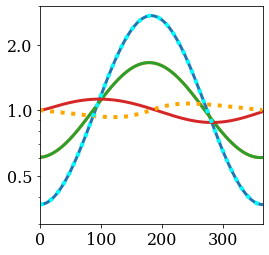

In [26]:
ax,fig=init_fig(aspect=(4,4))

SCALE=SLOW_Z/np.log(2)
T_EFF = t[::24*60]
ax.plot(T_EFF/(24*60),circuits_output['Activation'],lw=3)
ax.plot(T_EFF/(24*60),circuits_output['NegativeFeedback'],lw=3)
ax.plot(T_EFF/(24*60),circuits_output['NegativeFeedback'],lw=3)
ax.plot(T_EFF/(24*60),circuits_output['FCDCircuit'],lw=3)


ax.plot(T_EFF/(24*60),-SCALE*2*np.pi*np.sin(2*np.pi*T_EFF/TMAX)/(TMAX*(2+np.cos(2*np.pi*T_EFF/TMAX)))+1,c='orange',lw=4,linestyle='dotted')
ax.plot(T_EFF/(24*60),u(T_EFF),c='cyan',lw=4,linestyle='dotted')
ax.set_yscale('log')

for axis in [ax.yaxis,]:
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

ax.set_ylim(0.3,3)
ax.set_xlim(0,365)
ax.set_yticks([0.5, 1,2])
ax.set_xticks([0,100,200,300])

